# Microsoft Azure

## **대상 PoC 소개**

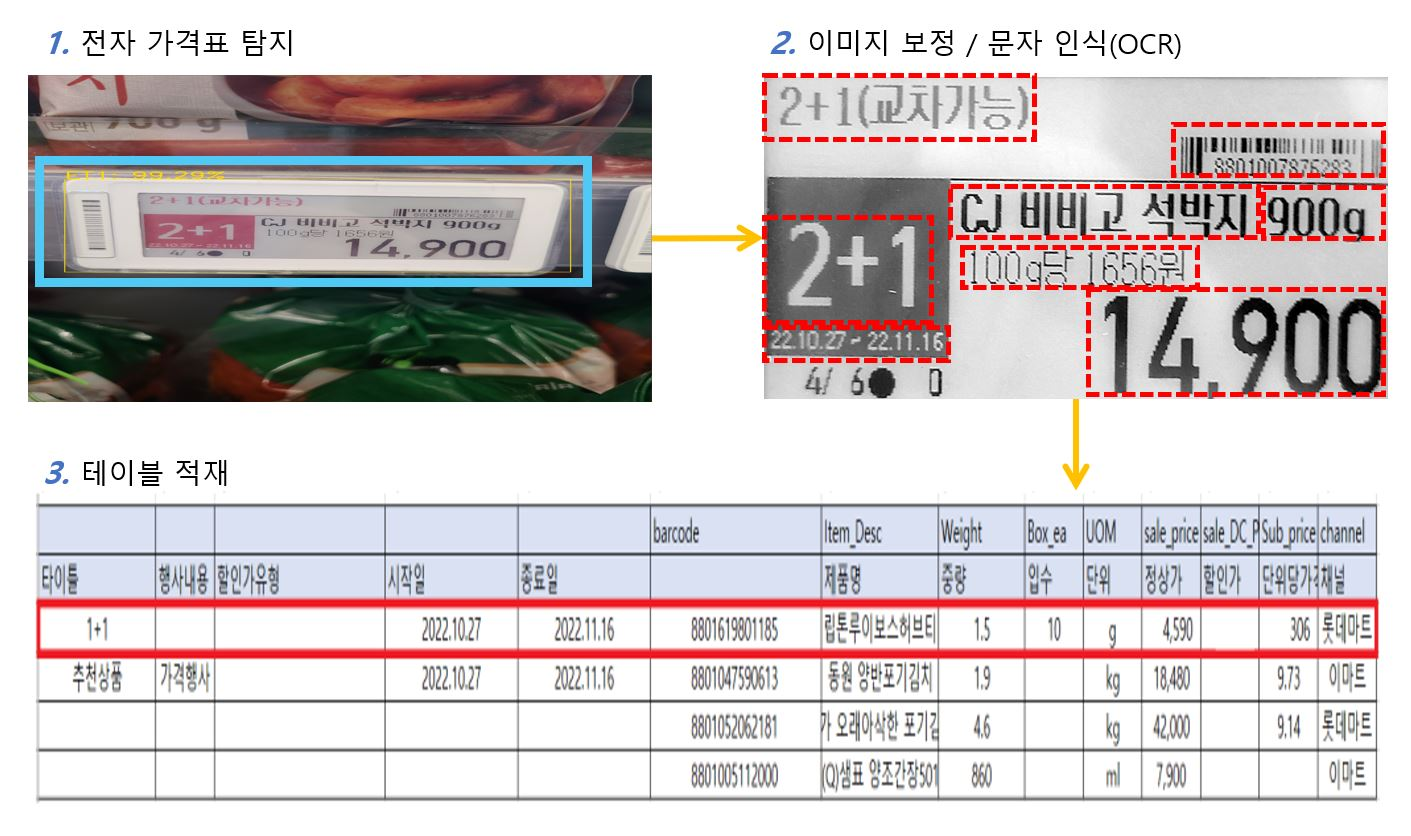

## 객체 탐지(Object Detectioin)  
> [Custom Vision Service 활용](https://www.customvision.ai/)
>> 이미지 레이블링 작업과 모델 학습 가능 (모델 파라미터 조정 ❌)

In [3]:
#Custom vision 패키지 설치
%pip install azure-cognitiveservices-vision-customvision==3.1.0

Note: you may need to restart the kernel to use updated packages.


In [1]:
from azure.cognitiveservices.vision.customvision.prediction import CustomVisionPredictionClient
from msrest.authentication import ApiKeyCredentials

from imutils.perspective import four_point_transform
from PIL import Image, ImageDraw, ImageFont
from os.path import isfile, isdir, join
from matplotlib import pyplot as plt

import numpy as np
import pathlib
import imutils
import time
import os
import cv2


from dotenv import load_dotenv

**dotenv 라이브러리로 현재 디렉토리에 있는 .env 파일로 부터 환경 변수 읽어오기~!**

In [5]:
load_dotenv()
prediction_endpoint = os.getenv('PredictionEndpoint')
prediction_key = os.getenv('PredictionKey')
project_id = os.getenv('ProjectID')
model_name = os.getenv('ModelName')

In [6]:
# Authenticate a client for the training API
credentials = ApiKeyCredentials(in_headers={"Prediction-key": prediction_key})
prediction_client = CustomVisionPredictionClient(endpoint=prediction_endpoint, credentials=credentials)

**모델 예측**

> 분류 모델: prediction_client.**classify**_image()  
> 탐지 모델: prediction_client.**detect**_image()

Detecting objects in ./Images/1667442160853-5.jpg
Results saved in  output.jpg


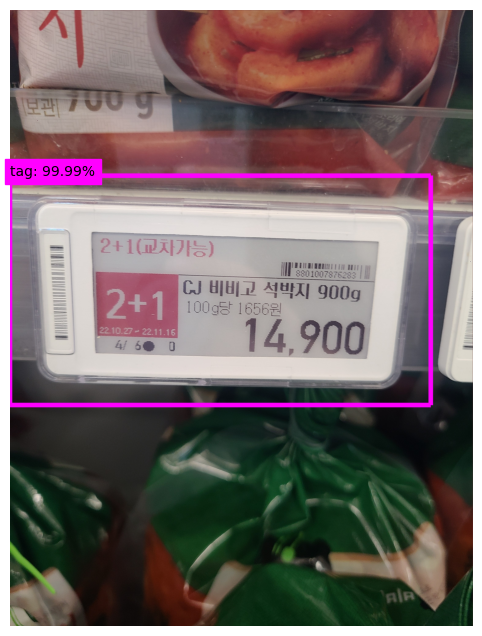

In [7]:
image_file = './Images/1667442160853-5.jpg'
print('Detecting objects in', image_file)
image = Image.open(image_file)
h, w, ch = np.array(image).shape

with open(image_file, mode="rb") as image_data:
    results = prediction_client.detect_image(project_id, model_name, image_data)

fig = plt.figure(figsize=(8, 8))
plt.axis('off')

draw = ImageDraw.Draw(image)
lineWidth = int(w/100)
color = 'magenta'
for prediction in results.predictions:
    if (prediction.probability*100) > 80:
        left = prediction.bounding_box.left * w 
        top = prediction.bounding_box.top * h 
        height = prediction.bounding_box.height * h
        width =  prediction.bounding_box.width * w
        # Draw the box
        points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top))
        draw.line(points, fill=color, width=lineWidth)

        plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)
plt.imshow(image)
outputfile = 'output.jpg'
plt.savefig(outputfile)
print('Results saved in ', outputfile)    

In [32]:
path = './Images'

tag: 99.99% 1667442160853-5.jpg


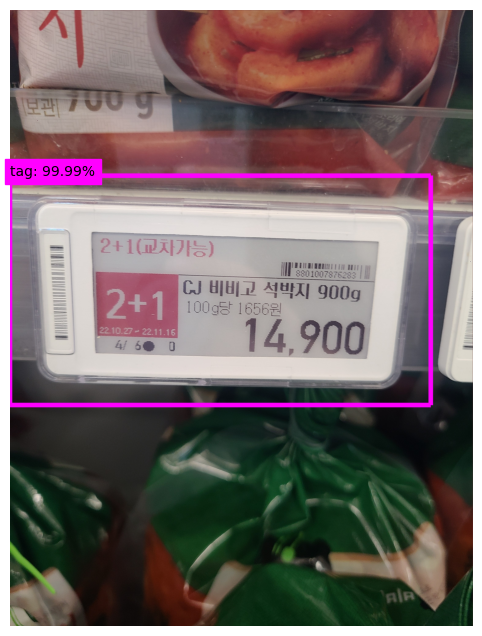

In [36]:
pred_label , pred_image = [], []

for img in (os.listdir(path)):
    try:
        if pathlib.Path(join(path, img)).suffix == '.jpg':    
            image = Image.open(join(path, img)) 

            h, w, c = np.array(image).shape

            with open(join(path, img), mode="rb") as image_data:
                results = prediction_client.detect_image(project_id, model_name, image_data)

            fig = plt.figure(figsize=(8, 8))
            plt.axis('off')   

            draw = ImageDraw.Draw(image)
            lineWidth = int(w/100)

            color = 'magenta'        

            n=0
            for prediction in results.predictions:
                if (prediction.probability*100) > 80:
                    print(f"{prediction.tag_name}: {prediction.probability * 100 :.2f}%", img)
                    img_name = img.split('.')[0]
                    
                    left = prediction.bounding_box.left * w
                    top = prediction.bounding_box.top * h
                    height = prediction.bounding_box.height * h
                    width =  prediction.bounding_box.width * w     

                    points = ((left,top), (left+width,top), (left+width,top+height), (left,top+height),(left,top)) 
                    draw.line(points, fill=color, width=lineWidth)

                    plt.annotate(prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100),(left,top), backgroundcolor=color)

                    img1 = cv2.imread(join(path, img))

                    cropped_img = img1[abs(int(top)): abs(int(top + height)), abs(int(left)): abs(int(left + width))]

                    cv2.imwrite(path + '/crop_' + img_name + '_' + str(n) + '.jpg', cropped_img)

    except Exception as ex:
        print(ex)

plt.imshow(image)        


In [38]:
def loadImage(file_path):

    src = cv2.imread(file_path, cv2.IMREAD_COLOR)

    retval, buf = cv2.imencode('.webp',
                               src,
                               [cv2.IMWRITE_WEBP_QUALITY, 100])

    # webp(web+picture)의 장점은 같은 품질의 이미지를 만들 때 기존의 이미지 포맷보다 파일 크기가 더 작아짐
    # 기본적으로 IMWRITE_WEBP_QUALITY을 사용해서 품질 결정
    # src:이미지, retval:압축결과(true/false), buf: 인코딩된 이미지                 
    return src, retval, buf


In [39]:
for crop in os.listdir(path):
    if pathlib.Path(join(path, img)).suffix == '.jpg' and 'crop' in crop:
        img_name = crop.split('.')[0]
        src, retval, buf = loadImage(join(path, img_name + '.jpg'))

        org_image = cv2.imdecode(buf, cv2.IMREAD_COLOR)

        image1 = org_image.copy() 
        image1 = imutils.resize(image1, width=500)
        ratio = org_image.shape[0] / float(image1.shape[0]) 

        image1 = cv2.bilateralFilter(image1, 5, 75, 75) 
        gray = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5,5),0)

        rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (7,7)) 
        dilated = cv2.dilate(blurred, rectKernel)
        edged = cv2.Canny(dilated, 30, 50)

        cv2.imwrite(path + "/edged_" + img_name + '_' + str(n) + '.jpg', edged)

        cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

        tagCnt = None

        for c in cnts:
            peri = cv2.arcLength(c, True) 
            approx = cv2.approxPolyDP(c, 0.05* peri, True) 

            if len(approx) == 4:
                tagCnt = approx
                break

        if tagCnt is None:
            print('None')    

        output = image1.copy()
        cv2.drawContours(output, [tagCnt], -1, (0, 255, 0), 2)    

        cv2.imwrite(path + "/Outline_" + img, output)

        tag = four_point_transform(org_image, tagCnt.reshape(4, 2)*ratio)
        
        if tag.shape[0] > 100 and tag.shape[1] > 100:
            pred_label.append(prediction.tag_name)
            for imgg in img.split('.')[:-1]:
                pred_image.append(imgg+'_'+str(n))
            cv2.imwrite(path + "/Transform_" + img_name + '_' + str(n) + '.jpg', tag)
        else:
            print("not exist contour")
        n += 1

In [41]:
for img in (os.listdir(path)):
    if "Transform_" in img and pathlib.Path(join(path, img)).suffix == '.jpg':
        tag_img = cv2.imread(path + '/' + img)

        gray = cv2.cvtColor(tag_img, cv2.COLOR_BGR2GRAY)

        alpha = 1.0
        func = (1 + alpha) * gray - (alpha * 128)
        dst = np.clip(func, 0, 255).astype(np.uint8)

        cv2.imwrite(path + '/erode_' + img, dst)     

print('Results saved.')

Results saved.


## 광학 인식(OCR)  
> [Vision Studio Service 활용](https://portal.vision.cognitive.azure.com/demo/extract-text-from-images)  
>> 이미 빌드 되어있는 모델 활용 (모델 학습 ❌)

In [42]:
%pip install azure.cognitiveservices.vision.computervision

In [43]:
from operator import truediv
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from azure.cognitiveservices.vision.computervision.models import OperationStatusCodes
from azure.cognitiveservices.vision.computervision.models import VisualFeatureTypes
from msrest.authentication import CognitiveServicesCredentials

from array import array
import os
from PIL import Image, ImageDraw
import sys
import time

In [44]:
subscription_key = "7dccb7dce7ed45f984b2e5ed4061c733" 
endpoint = "https://ocrstudy.cognitiveservices.azure.com/" 

computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

In [45]:
def list_chunk_to_tuple(lst, n):
    return [tuple(lst[i: i + n]) for i in range(0, len(lst), n)]

In [46]:
fileNames, oneTxtROIFilName = [], []

for fileName in os.listdir(path):
    if ('erode' in fileName and (os.path.splitext(fileName)[1] == '.JPG' or os.path.splitext(fileName)[1] == '.jpg')):
        fileName = os.path.splitext(fileName)[0]
        print("Start!!!")
        
        oneJpgFilePath = os.path.join(path, fileName) + '.jpg'

        oneJpgROIFilePath = os.path.join(path, fileName) + '_ROI.jpg'

        oneTetROIFilePath = os.path.join(path, fileName) + '_ROI.txt'

        img = Image.open(oneJpgFilePath)

        read_image = open(oneJpgFilePath, "rb")

        read_response = computervision_client.read_in_stream(read_image, raw=True)

        read_operation_location = read_response.headers["Operation-Location"]

        operation_id = read_operation_location.split("/")[-1]


        while True:
            read_result = computervision_client.get_read_result(operation_id)
            if read_result.status not in ['notStarted', 'running']:
                break
            print('Waiting for result...')
            time.sleep(10)    

        if read_result.status == OperationStatusCodes.succeeded:
            draw = ImageDraw.Draw(img)
            for text_result in read_result.analyze_result.read_results:
                with open(oneTetROIFilePath, 'w', encoding='UTF-8') as ocr_txt_file:
                    for line in text_result.lines:
                        ocr_txt_file.write(line.text + '\n')
                        points = list_chunk_to_tuple(line.bounding_box, 2)
                        draw.polygon((points[0], points[1], points[2], points[3]), outline="blue")
                        print(line.text)
                        print(points)

        img.save(oneJpgROIFilePath, "JPEG")
        oneTxtROIFilName.append(oneTetROIFilePath)
        img.close()

        print('')

Start!!!
operation_id 42fe38a9-0519-421a-9f76-7a5b93f58c17
Waiting for result...
2+1(교차가능)
[(44.0, 14.0), (785.0, 14.0), (784.0, 130.0), (44.0, 125.0)]
8801007876283
[(1319.0, 186.0), (1733.0, 187.0), (1733.0, 238.0), (1319.0, 237.0)]
2+1
[(61.0, 330.0), (462.0, 355.0), (457.0, 535.0), (72.0, 554.0)]
CJ 비비고 석박지 900g
[(574.0, 262.0), (1775.0, 272.0), (1773.0, 401.0), (573.0, 381.0)]
100g당 1656원
[(597.0, 402.0), (1244.0, 406.0), (1243.0, 503.0), (597.0, 497.0)]
14.900
[(991.0, 511.0), (1838.0, 516.0), (1837.0, 749.0), (991.0, 739.0)]
22.10.27 - 22.11.16
[(11.0, 589.0), (526.0, 595.0), (526.0, 651.0), (10.0, 646.0)]
4/
[(107.0, 677.0), (230.0, 675.0), (229.0, 750.0), (110.0, 754.0)]

